In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/9517/Project/elpv-dataset-master/'

/content/drive/.shortcut-targets-by-id/1ist1JnAWCBLrAQUo9uHjAbOtaz69G5Wc/9517/Project/elpv-dataset-master


# Data Preprocessing

In [3]:
# Copyright (C) 2018 Sergiu Deitsch
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.
#
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
#
# 3. Neither the name of the copyright holder nor the names of its contributors
#    may be used to endorse or promote products derived from this software without
#    specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch,torchvision
from torchvision import models,transforms,datasets
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.modules.activation import LogSoftmax
from sklearn.metrics import confusion_matrix, recall_score, f1_score
import cv2


def load_dataset(fname=None):
    if fname is None:
        # Assume we are in the utils folder and get the absolute path to the
        # parent directory.
        fname = os.path.abspath(os.path.join(os.path.dirname(__file__),
                                             os.path.pardir))
        fname = os.path.join(fname, 'labels.csv')

    data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=[
                         'path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    def load_cell_image(fname):
        with Image.open(fname) as image:
            return np.asarray(image)

    dir = os.path.dirname(fname)

    images = np.array([load_cell_image(os.path.join(dir, fn))
                       for fn in image_fnames])

    return images, probs, types, image_fnames

# cause load all data could be very sloow. here i extracted the first 200 or 500 rows experimenting data.

In [4]:
import csv

source_file = "labels.csv"
new_file = "labels_200.csv"

with open(source_file, 'r', newline='') as source_csvfile:
    reader = csv.reader(source_csvfile)

    with open(new_file, 'w', newline='') as new_csvfile:
        writer = csv.writer(new_csvfile)

        header = next(reader)
        writer.writerow(header)
        for i, row in enumerate(reader):
            if i < 500:
                writer.writerow(row)
            else:
                break

print(f"the first 200 rows of data have been extracted and saved to '{new_file}'")


the first 200 rows of data have been extracted and saved to 'labels_200.csv'


In [5]:
images,probs,types,image_fnames = load_dataset('/content/drive/MyDrive/9517/Project/elpv-dataset-master/labels.csv')
# takes a lot of time and can't be accelerated by using GPU.

# images.shape: (2624, 1,300, 300) 2624:number, 300:height,width, 1:channel
# the type of images is grayscale, hence can not directly be processed using VGG16.

# split data into Train and Test. (Validation can be added)

In [6]:
overall,mono,poly = [],[],[]
for i in range(len(images)):
    sample = {
        "images_fnames": image_fnames[i],
        "class": probs[i],
        "type": types[i]
    }
    overall.append(sample)
    if types[i] == 'mono':
      mono.append(sample)
    else:
      poly.append(sample)
# train test split
overall_train_dataset, overall_test_dataset = train_test_split(overall, test_size=0.25,shuffle=True, random_state=42)
overall_train_dataset, overall_valid_dataset = train_test_split(overall_train_dataset, test_size=0.25,shuffle=True, random_state=42)
mono_train_dataset, mono_test_dataset = train_test_split(mono, test_size=0.25,shuffle=True, random_state=42)
mono_train_dataset, mono_valid_dataset = train_test_split(mono_train_dataset, test_size=0.25,shuffle=True, random_state=42)
poly_train_dataset, poly_test_dataset = train_test_split(poly, test_size=0.25,shuffle=True, random_state=42)
poly_train_dataset, poly_valid_dataset = train_test_split(poly_train_dataset, test_size=0.25,shuffle=True, random_state=42)
print(len(overall_train_dataset))
print(len(mono_train_dataset))
print(len(poly_train_dataset))
print(overall_train_dataset)

1476
603
871
[{'images_fnames': 'images/cell0155.png', 'class': 1.0, 'type': 'poly'}, {'images_fnames': 'images/cell1944.png', 'class': 0.0, 'type': 'poly'}, {'images_fnames': 'images/cell2331.png', 'class': 0.3333333333333333, 'type': 'poly'}, {'images_fnames': 'images/cell1309.png', 'class': 0.0, 'type': 'mono'}, {'images_fnames': 'images/cell0539.png', 'class': 1.0, 'type': 'mono'}, {'images_fnames': 'images/cell0690.png', 'class': 0.0, 'type': 'poly'}, {'images_fnames': 'images/cell0233.png', 'class': 1.0, 'type': 'poly'}, {'images_fnames': 'images/cell0607.png', 'class': 1.0, 'type': 'poly'}, {'images_fnames': 'images/cell2094.png', 'class': 0.0, 'type': 'poly'}, {'images_fnames': 'images/cell1921.png', 'class': 0.3333333333333333, 'type': 'poly'}, {'images_fnames': 'images/cell1965.png', 'class': 0.6666666666666666, 'type': 'poly'}, {'images_fnames': 'images/cell0897.png', 'class': 1.0, 'type': 'poly'}, {'images_fnames': 'images/cell1501.png', 'class': 0.0, 'type': 'mono'}, {'ima

# classifiy different class of images into corresponding image folders in order to do the transformation. here i only finished overall and the mono and poly haven't been done

In [ ]:
import os
import shutil

source_directory = "images"

# Create folders for each label
labels = np.unique(probs)
for label in labels:
    os.makedirs(f'/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/mono/train/{str(label)}', exist_ok=True)
    os.makedirs(f'/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/mono/valid/{str(label)}', exist_ok=True)
    os.makedirs(f'/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/mono/test/{str(label)}', exist_ok=True)
    os.makedirs(f'/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/overall/train/{str(label)}', exist_ok=True)
    os.makedirs(f'/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/overall/valid/{str(label)}', exist_ok=True)
    os.makedirs(f'/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/overall/test/{str(label)}', exist_ok=True)
    os.makedirs(f'/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/poly/train/{str(label)}', exist_ok=True)
    os.makedirs(f'/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/poly/valid/{str(label)}', exist_ok=True)
    os.makedirs(f'/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/poly/test/{str(label)}', exist_ok=True)


# Loop through the images and labels
def classify_image(datastet,path):
  for i in range(len(datastet)):
      source_path = os.path.join(datastet[i]['images_fnames'])
      destination_path = os.path.join(path,str(datastet[i]['class']))
      # Copy the image to the corresponding label folder
      shutil.copy(source_path, destination_path)


classify_image(overall_train_dataset,"/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/overall/train/")
classify_image(overall_valid_dataset,"/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/overall/valid/")
classify_image(overall_test_dataset,"/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/overall/test/")
classify_image(mono_train_dataset,"/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/mono/train/")
classify_image(mono_valid_dataset,"/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/mono/valid/")
classify_image(mono_test_dataset,"/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/mono/test/")
classify_image(poly_train_dataset,"/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/poly/train/")
classify_image(poly_valid_dataset,"/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/poly/valid/")
classify_image(poly_test_dataset,"/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/poly/test/")

# Data transformation: image augmentation, Tensor transformation.


In [7]:
overall_dataset = '/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/overall/'
mono_dataset = '/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/mono/'
poly_dataset = '/content/drive/MyDrive/9517/Project/elpv-dataset-master/cnn_dataset/poly/'


train_overall = os.path.join(overall_dataset,'train')
valid_overall = os.path.join(overall_dataset,'valid')
test_overall = os.path.join(overall_dataset,'test')

train_mono = os.path.join(mono_dataset,'train')
valid_mono = os.path.join(mono_dataset,'valid')
test_mono = os.path.join(mono_dataset,'test')

train_poly = os.path.join(poly_dataset,'train')
valid_poly = os.path.join(poly_dataset,'valid')
test_poly = os.path.join(poly_dataset,'test')

bs = 32
num_classes = len(os.listdir(train_overall))
print("how many classes there? :",num_classes)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomResizedCrop(size=(224,224), scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456,0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456,0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456,0.406], std=[0.229, 0.224, 0.225])
    ])
}

data = {
    'train': datasets.ImageFolder(root=train_overall, transform=data_transforms['train']),
    'test': datasets.ImageFolder(root=test_overall, transform=data_transforms['test']),
    'valid': datasets.ImageFolder(root=valid_overall, transform=data_transforms['valid'])
}


data_mono= {
    'train': datasets.ImageFolder(root=train_mono, transform=data_transforms['train']),
    'test': datasets.ImageFolder(root=test_mono, transform=data_transforms['test']),
    'valid': datasets.ImageFolder(root=valid_mono, transform=data_transforms['valid'])
}

data_poly= {
    'train': datasets.ImageFolder(root=train_poly, transform=data_transforms['train']),
    'test': datasets.ImageFolder(root=test_poly, transform=data_transforms['test']),
    'valid': datasets.ImageFolder(root=valid_poly, transform=data_transforms['valid'])
}

idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
classes_names = data['train'].classes
print(classes_names)
print(idx_to_class)


how many classes there? : 4
['0.0', '0.3333333333333333', '0.6666666666666666', '1.0']
{0: '0.0', 1: '0.3333333333333333', 2: '0.6666666666666666', 3: '1.0'}


# batch size used is 16, we have got 1968 training image. Hence we have got 123 training sets.

In [8]:
overall_train_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
overall_test_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)
overall_valid_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

mono_train_loader = DataLoader(data_mono['train'], batch_size=bs, shuffle=True)
mono_test_loader = DataLoader(data_mono['test'], batch_size=bs, shuffle=True)
mono_valid_loader = DataLoader(data_mono['valid'], batch_size=bs, shuffle=True)

poly_train_loader = DataLoader(data_poly['train'], batch_size=bs, shuffle=True)
poly_test_loader = DataLoader(data_poly['test'], batch_size=bs, shuffle=True)
poly_valid_loader = DataLoader(data_poly['valid'], batch_size=bs, shuffle=True)

print("the number of dataset in overall_train_loader after being batchsized:", len(overall_train_loader))
print("the number of dataset in overall_valid_loader after being batchsized:", len(overall_valid_loader))
print("the number of dataset in overall_test_loader after being batchsized:", len(overall_test_loader))

the number of dataset in overall_train_loader after being batchsized: 30
the number of dataset in overall_valid_loader after being batchsized: 18
the number of dataset in overall_test_loader after being batchsized: 21


### Use GPU

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
print(device)

cuda:0


# Check out the vgg19 structure.

> Indented block



In [10]:
vgg19 = models.vgg19_bn(pretrained = True)
vgg19 = vgg19.to(device)
print(vgg19)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:04<00:00, 128MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Customize the structure

In [11]:
"""for param in 19.classifier.parameters():
    param.requires_grad = True"""
fc_inputs = vgg19.classifier[6].in_features
print(fc_inputs)
features = list(vgg19.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(fc_inputs, 4)])
features.extend([nn.LogSoftmax(dim=1)])
vgg19.classifier = nn.Sequential(*features) # Replace the model classifier
print("VGG19 structure after customized")
print(vgg19)
vgg19 = vgg19.to(device)

4096
VGG19 structure after customized
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil

# These parameters using in Adam are from the essay.

In [12]:
criterion = nn.NLLLoss()

# why we choose Adam? >depends on our dataset size, Adam can better fit smaller dataset.
optimizer = optim.SGD(vgg19.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-8)


# This training structure can be found on lecture slides.

In [13]:
def eval_model(model,loss_criterion,overall_test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


    all_predictions = []
    all_labels = []

    test_acc = 0.0
    test_loss = 0.0

    with torch.no_grad():

        # Set to evaluation mode
        model.train(False)
        model.eval()

        # Validation loop
        for j, target in enumerate(overall_test_loader):
            if j % (len(overall_test_loader)-1) == 0 and j != 0:
              print("\rTest batch {}/{}".format(j, len(overall_test_loader)), flush=True)
            labels = target[1].to(device)
            inputs = target[0].to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)
            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item()

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            #
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item()

            # Find average test loss and test accuracy
        avg_test_loss = test_loss/(len(overall_test_loader))
        avg_test_acc = test_acc/(len(overall_test_loader))
        conf_matrix = confusion_matrix(all_labels, all_predictions)
        recall = recall_score(all_labels, all_predictions, average='macro')
        f1 = f1_score(all_labels, all_predictions, average='macro')



        print("Test Loss: {:.4f}".format(avg_test_loss))
        print("Test Accuracy: {:.4f}%".format(avg_test_acc*100))
        print("Recall: {:.4f}".format(recall))
        print("F1 Score: {:.4f}".format(f1))
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()
        print("-------------------")

In [14]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
def train_and_validate(model,loss_criterion,optimizer,overall_train_loader,overall_valid_loader,epochs=25):
  start = time.time()
  history = []
  best_loss = 100000.0
  best_epoch = None
  epoch_time = 0

  for epoch in range(epochs):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, epochs))

    # Set to training mode
    model.train(True)

    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0
    for i,target in enumerate(overall_train_loader):
        labels = target[1].to(device)
        inputs = target[0].to(device)
        optimizer.zero_grad()

        # Forward pass - compute outputs on input data using the model
        outputs = model(inputs)

        # Compute loss
        loss = loss_criterion(outputs, labels)

        # Backpropagate the gradients
        loss.backward()

        # Update the parameters
        optimizer.step()

        # loss: tensor(1.3783, device='cuda:0', grad_fn=<NllLossBackward0>)
        # loss.item(): 1.3783142566680908
        # inputs.size(0) = batch_size
        train_loss += loss.item()

        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))


        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item()

        #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, target in enumerate(overall_valid_loader):
            labels = target[1].to(device)
            inputs = target[0].to(device)
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            valid_loss += loss.item()


            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            # ret: max_value in the direction of row
            # predictions: index of the max_value

            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item()
            #print("Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
    if valid_loss < best_loss:
      best_loss = valid_loss
      best_epoch = epoch
    avg_train_loss = train_loss/(len(overall_train_loader))
    avg_train_acc = train_acc/(len(overall_train_loader))

    # Find average training loss and training accuracy
    avg_valid_loss = valid_loss/(len(overall_valid_loader))
    avg_valid_acc = valid_acc/(len(overall_valid_loader))

    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

    epoch_end = time.time()
    epoch_time += (epoch_end-epoch_start)

    print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc, avg_valid_loss, avg_valid_acc, epoch_end-epoch_start))

    # Save if the model has best accuracy till now
    # torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
  return model, history, best_epoch

Test before training:
Test batch 20/21
Test Loss: 1.3077
Test Accuracy: 51.2202%
Recall: 0.3229
F1 Score: 0.3150


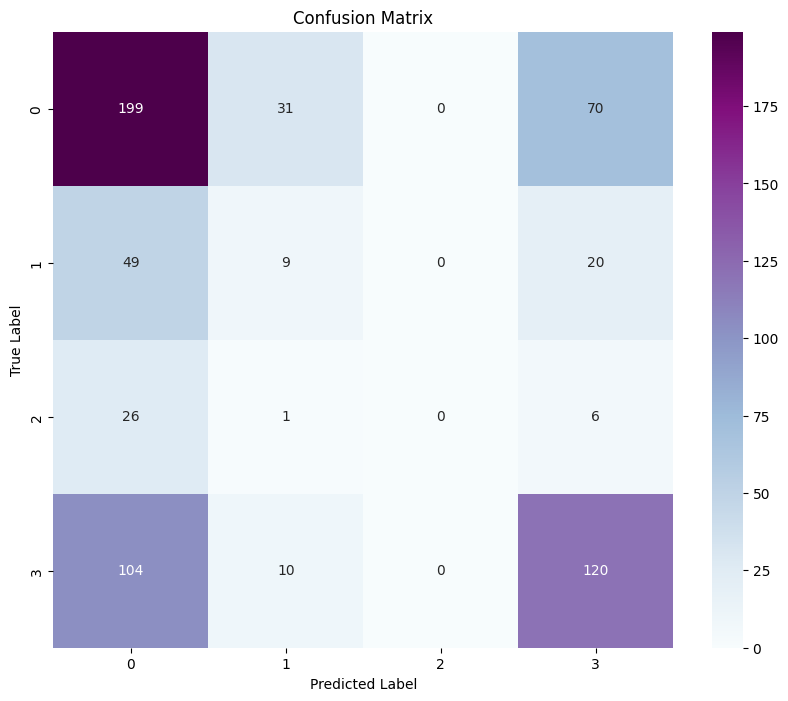

-------------------


In [16]:
print("Test before training:")
eval_model(vgg19, criterion,overall_test_loader)

## The overall modules

In [17]:
num_epochs = 15
trained_model, history, best_epoch = train_and_validate(vgg19, criterion, optimizer,overall_train_loader,overall_valid_loader, num_epochs)


Epoch: 1/15
Epoch : 000, Training: Loss - 1.1964, Accuracy - 0.4638%, 
		Validation : Loss - 0.9999, Accuracy - 0.6649%, Time: 964.0383s
Epoch: 2/15
Epoch : 001, Training: Loss - 1.0499, Accuracy - 0.5576%, 
		Validation : Loss - 1.0638, Accuracy - 0.4578%, Time: 35.8756s
Epoch: 3/15
Epoch : 002, Training: Loss - 1.0065, Accuracy - 0.5681%, 
		Validation : Loss - 0.9732, Accuracy - 0.5295%, Time: 35.7660s
Epoch: 4/15
Epoch : 003, Training: Loss - 0.9511, Accuracy - 0.5770%, 
		Validation : Loss - 0.9086, Accuracy - 0.5781%, Time: 36.8644s
Epoch: 5/15
Epoch : 004, Training: Loss - 0.9246, Accuracy - 0.5969%, 
		Validation : Loss - 0.9626, Accuracy - 0.5047%, Time: 36.1841s
Epoch: 6/15
Epoch : 005, Training: Loss - 0.8533, Accuracy - 0.6388%, 
		Validation : Loss - 0.9053, Accuracy - 0.5885%, Time: 36.5036s
Epoch: 7/15
Epoch : 006, Training: Loss - 0.8886, Accuracy - 0.6128%, 
		Validation : Loss - 0.8988, Accuracy - 0.5606%, Time: 36.5326s
Epoch: 8/15
Epoch : 007, Training: Loss - 0.870

# -------------------------------


Overall modules After training:
Test batch 20/21
Test Loss: 0.9329
Test Accuracy: 59.3452%
Recall: 0.4925
F1 Score: 0.4326


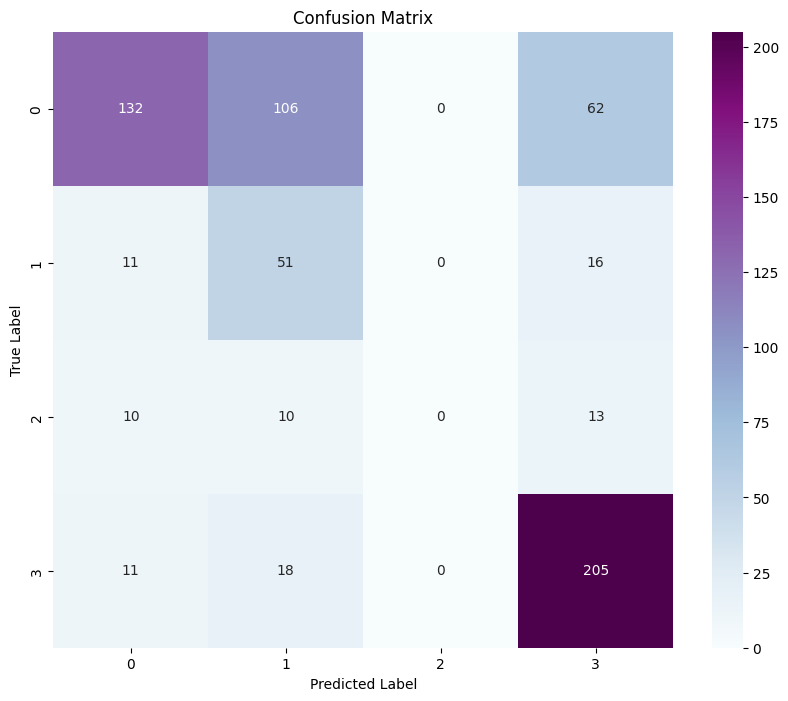

-------------------


In [18]:
print("Overall modules After training:")
eval_model(vgg19, criterion, overall_test_loader)

## The mono modules

In [19]:
trained_model, history, best_epoch = train_and_validate(vgg19, criterion, optimizer,mono_train_loader,mono_valid_loader, num_epochs)


Epoch: 1/15
Epoch : 000, Training: Loss - 0.7276, Accuracy - 0.7265%, 
		Validation : Loss - 0.6959, Accuracy - 0.7241%, Time: 561.9330s
Epoch: 2/15
Epoch : 001, Training: Loss - 0.6677, Accuracy - 0.7603%, 
		Validation : Loss - 0.6056, Accuracy - 0.7933%, Time: 21.9610s
Epoch: 3/15
Epoch : 002, Training: Loss - 0.5970, Accuracy - 0.7789%, 
		Validation : Loss - 0.6884, Accuracy - 0.7507%, Time: 22.2663s
Epoch: 4/15
Epoch : 003, Training: Loss - 0.5626, Accuracy - 0.7879%, 
		Validation : Loss - 0.6593, Accuracy - 0.7433%, Time: 21.9419s
Epoch: 5/15
Epoch : 004, Training: Loss - 0.5926, Accuracy - 0.7626%, 
		Validation : Loss - 0.5877, Accuracy - 0.7940%, Time: 22.5770s
Epoch: 6/15
Epoch : 005, Training: Loss - 0.5477, Accuracy - 0.7811%, 
		Validation : Loss - 0.5992, Accuracy - 0.7816%, Time: 22.1346s
Epoch: 7/15
Epoch : 006, Training: Loss - 0.5244, Accuracy - 0.8138%, 
		Validation : Loss - 0.5635, Accuracy - 0.7972%, Time: 22.2265s
Epoch: 8/15
Epoch : 007, Training: Loss - 0.507

Mono modules After training:
Test batch 9/10
Test Loss: 0.6173
Test Accuracy: 77.3065%
Recall: 0.5668
F1 Score: 0.5445


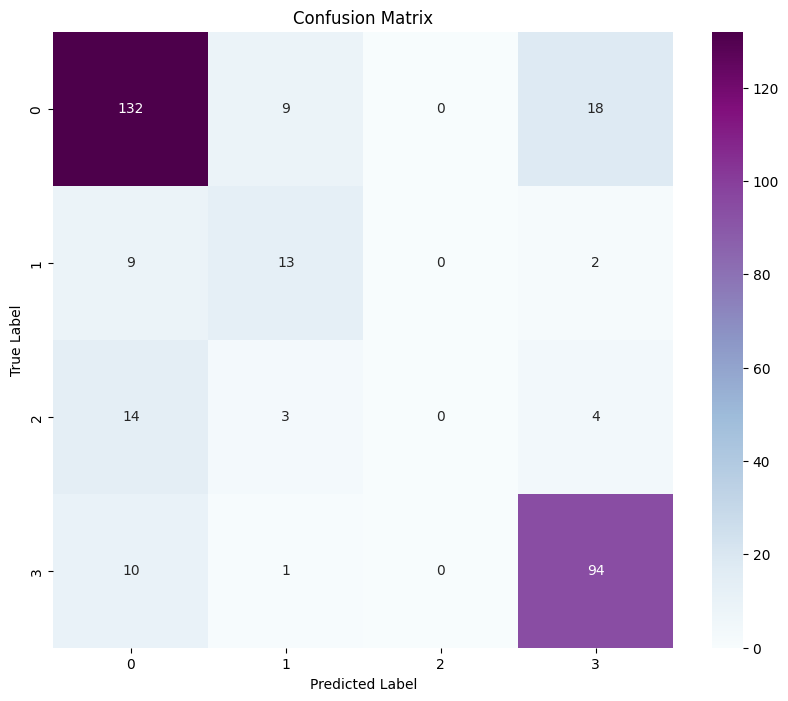

-------------------


In [20]:
print("Mono modules After training:")
eval_model(vgg19, criterion,mono_test_loader)

## The Poly modules

In [21]:
trained_model, history, best_epoch = train_and_validate(vgg19, criterion, optimizer,poly_train_loader,poly_valid_loader, num_epochs)


Epoch: 1/15
Epoch : 000, Training: Loss - 0.9324, Accuracy - 0.6088%, 
		Validation : Loss - 0.8474, Accuracy - 0.6058%, Time: 567.2894s
Epoch: 2/15
Epoch : 001, Training: Loss - 0.7538, Accuracy - 0.7026%, 
		Validation : Loss - 0.7451, Accuracy - 0.6908%, Time: 21.8233s
Epoch: 3/15
Epoch : 002, Training: Loss - 0.7023, Accuracy - 0.7206%, 
		Validation : Loss - 0.7465, Accuracy - 0.7091%, Time: 22.0259s
Epoch: 4/15
Epoch : 003, Training: Loss - 0.7004, Accuracy - 0.7257%, 
		Validation : Loss - 0.8180, Accuracy - 0.6073%, Time: 21.9057s
Epoch: 5/15
Epoch : 004, Training: Loss - 0.6543, Accuracy - 0.7452%, 
		Validation : Loss - 0.7997, Accuracy - 0.6748%, Time: 21.9551s
Epoch: 6/15
Epoch : 005, Training: Loss - 0.6581, Accuracy - 0.7322%, 
		Validation : Loss - 0.9030, Accuracy - 0.5846%, Time: 22.0472s
Epoch: 7/15
Epoch : 006, Training: Loss - 0.5976, Accuracy - 0.7756%, 
		Validation : Loss - 0.8999, Accuracy - 0.5787%, Time: 22.0777s
Epoch: 8/15
Epoch : 007, Training: Loss - 0.628

Poly modules After training:
Test batch 13/14
Test Loss: 0.7463
Test Accuracy: 70.2782%
Recall: 0.5724
F1 Score: 0.5429


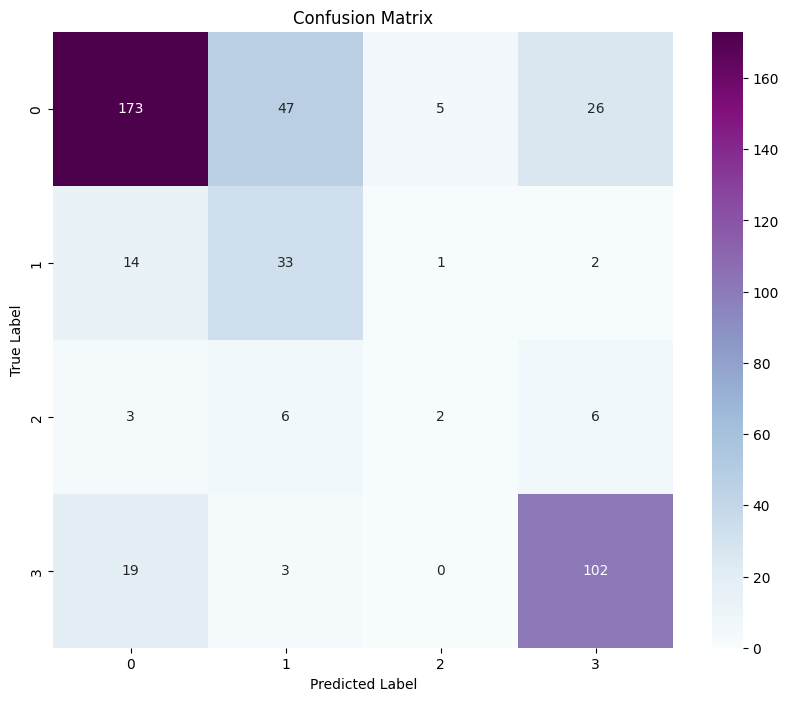

-------------------


In [23]:
print("Poly modules After training:")
eval_model(vgg19, criterion,poly_test_loader)